In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96
from models.clstm import cLSTM, train_model_ista

import pandas as pd

In [55]:
device = torch.device('cuda')

In [73]:
PATH = 'dataset/train/v_ApPxnw_Jffg_c016/'  #v_ApPxnw_Jffg_c016

gt_path = PATH + 'gt/gt.txt'

df = pd.read_csv(gt_path, sep=',', header=None)

df.head()

,0,1,2,3,4,5,6,7,8
0,1,0,696,442,52,123,1,1,1
1,1,1,1020,352,65,110,1,1,1
2,1,2,609,411,35,115,1,1,1
3,1,3,444,371,57,142,1,1,1
4,1,4,416,354,56,151,1,1,1


In [74]:
df.groupby(1).count()

,0,2,3,4,5,6,7,8
1,,,,,,,,
0,219,219,219,219,219,219,219,219
1,291,291,291,291,291,291,291,291
2,245,245,245,245,245,245,245,245
3,352,352,352,352,352,352,352,352
4,352,352,352,352,352,352,352,352
5,352,352,352,352,352,352,352,352
6,352,352,352,352,352,352,352,352
7,352,352,352,352,352,352,352,352
8,352,352,352,352,352,352,352,352


In [75]:
import numpy as np
from itertools import combinations

df.sort_values(by=0, inplace=True)

unique_frames = df[0].unique()

def get_players_in_scope(df, start_frame, end_frame):
    frames_in_scope = df[df[0].between(start_frame, end_frame)]
    player_counts = frames_in_scope.groupby(1)[0].count()
    qualified_players = player_counts[player_counts == (end_frame - start_frame + 1)]
    return qualified_players.index.tolist()

longest_scope = (0, 0)
players_in_longest_scope = []

for start_frame, end_frame in combinations(unique_frames, 2):
    if end_frame - start_frame > longest_scope[1] - longest_scope[0]:
        players = get_players_in_scope(df, start_frame, end_frame)
        if len(players) >= 3:
            longest_scope = (start_frame, end_frame)
            players_in_longest_scope = players

all_possible_players = players_in_longest_scope
selected_players = np.random.choice(players_in_longest_scope, 3, replace=False) if len(players_in_longest_scope) > 3 else players_in_longest_scope

print("Longest continuous frame scope:", longest_scope)
print("All possible player IDs in the scope:", all_possible_players)
print("Selected player IDs:", selected_players)

Longest continuous frame scope: (1, 352)
All possible player IDs in the scope: [3, 4, 5, 6, 7, 8, 10, 11]
Selected player IDs: [4 5 7]


In [77]:
df['central_point_x'] = df[2] + df[4] / 2
df['central_point_y'] = df[3] + df[5] / 2

In [78]:
df.head()

,0,1,2,3,4,5,6,7,8,central_point_x,central_point_y
0,1,0,696,442,52,123,1,1,1,722.0,503.5
10,1,11,44,388,43,109,1,1,1,65.5,442.5
9,1,10,4,429,53,112,1,1,1,30.5,485.0
7,1,7,191,383,48,91,1,1,1,215.0,428.5
6,1,6,131,473,45,143,1,1,1,153.5,544.5


In [79]:
df_chosen_players = df[df[1].isin(all_possible_players)]
df_chosen_players.head()

,0,1,2,3,4,5,6,7,8,central_point_x,central_point_y
10,1,11,44,388,43,109,1,1,1,65.5,442.5
9,1,10,4,429,53,112,1,1,1,30.5,485.0
7,1,7,191,383,48,91,1,1,1,215.0,428.5
6,1,6,131,473,45,143,1,1,1,153.5,544.5
8,1,8,230,371,47,98,1,1,1,253.5,420.0


In [80]:
pivot_x = df_chosen_players.pivot(index=0, columns=1, values='central_point_x').fillna(0)
pivot_y = df_chosen_players.pivot(index=0, columns=1, values='central_point_y').fillna(0)

In [81]:
pivot_x.head()

1,3,4,5,6,7,8,10,11
0,,,,,,,,
1,472.5,444.0,485.0,153.5,215.0,253.5,30.5,65.5
2,474.5,446.0,487.0,155.5,219.0,256.0,33.0,67.5
3,480.5,449.5,489.0,158.5,222.0,258.5,37.5,71.0
4,483.5,455.5,494.0,159.5,225.0,261.5,40.0,74.5
5,486.5,458.5,498.0,162.0,230.0,265.5,45.5,79.5


In [82]:
tensor_x = torch.tensor(pivot_x.values[None, :, :], dtype=torch.float32)
tensor_y = torch.tensor(pivot_y.values[None, :, :], dtype=torch.float32)

print(tensor_x.shape)  
print(tensor_y.shape)

torch.Size([1, 352, 8])
torch.Size([1, 352, 8])


In [83]:
tensor_x

tensor([[[472.5000, 444.0000, 485.0000,  ..., 253.5000,  30.5000,  65.5000],
         [474.5000, 446.0000, 487.0000,  ..., 256.0000,  33.0000,  67.5000],
         [480.5000, 449.5000, 489.0000,  ..., 258.5000,  37.5000,  71.0000],
         ...,
         [536.0000, 520.5000, 530.5000,  ..., 431.5000, 324.0000, 405.5000],
         [538.5000, 525.5000, 535.5000,  ..., 432.5000, 321.5000, 401.0000],
         [538.5000, 526.0000, 542.0000,  ..., 432.5000, 321.5000, 401.0000]]])

In [65]:
torch_xy = torch.cat((tensor_x, tensor_y), dim=0)
tensor_xy = torch_xy[:,:100,:]
tensor_xy.shape

torch.Size([2, 100, 9])

In [86]:
X = tensor_x.to(device)

clstm = cLSTM(X.shape[-1], hidden=10).to(device=device)

train_loss_list = train_model_ista(
    clstm, X, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000,lookback=60,
    check_every=50)

----------Iter = 50----------
Loss = 210348.843750
Variable usage = 100.00%
----------Iter = 100----------
Loss = 127506.039062
Variable usage = 98.44%
----------Iter = 150----------
Loss = 99474.500000
Variable usage = 95.31%
----------Iter = 200----------
Loss = 483206.125000
Variable usage = 100.00%
----------Iter = 250----------
Loss = 481108.156250
Variable usage = 98.44%
----------Iter = 300----------
Loss = 489386.000000
Variable usage = 98.44%
----------Iter = 350----------
Loss = 473694.437500
Variable usage = 96.88%
----------Iter = 400----------
Loss = 481024.625000
Variable usage = 100.00%
----------Iter = 450----------
Loss = 477176.843750
Variable usage = 100.00%
----------Iter = 500----------
Loss = 475007.281250
Variable usage = 100.00%
----------Iter = 550----------
Loss = 473928.375000
Variable usage = 100.00%
----------Iter = 600----------
Loss = 473378.062500
Variable usage = 100.00%
----------Iter = 650----------
Loss = 473085.656250
Variable usage = 100.00%
------

In [87]:
clstm.GC()

tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1]], device='cuda:0', dtype=torch.int32)

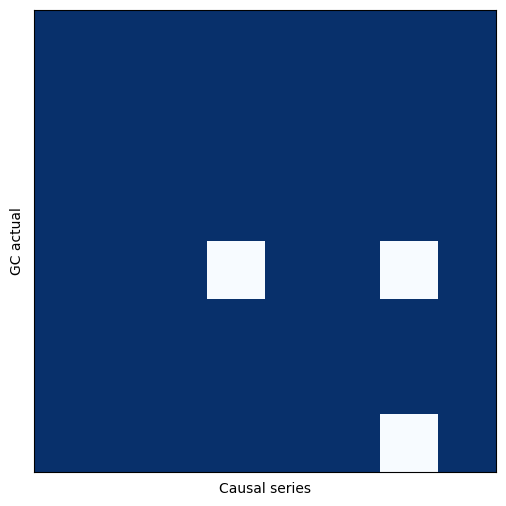

In [88]:
GC_est = clstm.GC().cpu().data.numpy()

plt.figure(figsize=(6, 6))
plt.imshow(GC_est, cmap='Blues', interpolation='nearest')

# Assuming you don't want ticks on the axes
plt.xticks([])
plt.yticks([])

# Labels for axes
plt.xlabel('Causal series')
plt.ylabel('GC actual')

# Show the plot
plt.show()